# Free Troposphere Level
This looks at what pressure level should be chosen to represent the free troposphere.

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p
from isca_tools.utils import area_weighting
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.aquaplanet_theory import get_delta_temp_quant_theory, get_gamma
from isca_tools.plot import label_subplots
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

2023-11-02 16:21:44,173 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [2]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'height']        # only keep variables required to compute relative humidity and MSE
# Load dataset
tau_lw_ref = 1
tau_lw_warm = 1.5
exp_dir = 'tau_sweep/aquaplanet/'
exp_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
n_exp = len(exp_names)
ds_base = []
albedo = []
tau_sw = []
tau_lw = []
for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    ds_base += [ds_use]      # only keep the surface values
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]

## Get datasets
Get one surface dataset for summer for each $\kappa$, combining all latitudes: `ds_all`. This combines the summer months in each hemisphere, e.g. negative latitudes will only correspond to times in December, January or February.

Also get an equivalent dataset consisting of free troposphere rather than surface values: `ds_all_ft`.

In [3]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

In [63]:
# Load in dataset with surface and free troposphere across all latitudes, for given season
use_time_start = 360*2

# Chose whether to only consider summer days for mean or all days
summer_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH 
use_summer = True      # if true, will set ds will only contain summer months. Do this outside tropics

ds = []  # need both all and summer day dataset
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds_base[i].sel(time=slice(use_time_start, np.inf))
        if use_summer:
            ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, summer_months['nh']).sel(lat=slice(0, 90))  
            ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, summer_months['sh']).sel(lat=slice(-90, 0)) 
            # Combine hemispheres and average over longitude, time and latitude.
            ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        ds += [ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1)).load()]
        pbar.update(1)
p_surface = float(ds[0].pfull[-1]) * 100

100%|██████████| 2/2 [00:07<00:00,  3.75s/it]


In [64]:
n_lat = ds[0].lat.shape[0]
n_pressure = ds[0].pfull.shape[0]
lat_weights = np.cos(np.deg2rad(ds[0].lat))     # latitude area weighting is just the cosine

In [65]:
# Select region to combine latitudes over for all but one of the plots below
# Tropics
# region = 'tropics'
# lat_min = 0
# lat_max = 20
# Extratropics
region = 'extratropics'
lat_min = 40
lat_max = 65
# Poles
# region = 'High Latitudes'
# lat_min = 70
# lat_max = 90
# Global
# region = 'Global'
# lat_min = 0
# lat_max = 90

lat_use_ind = np.where((np.abs(ds[0].lat) <= lat_max) & (np.abs(ds[0].lat) >= lat_min))[0]
lat_weights_use = lat_weights[lat_use_ind]
n_lat_use = len(lat_use_ind)

In [66]:
# Obtain the temperature profile conditioned on the near-surface temperature percentile
quant_plot_temp_profile = [1, 25, 50, 75, 99]
n_quant_temp_profile = len(quant_plot_temp_profile)

temp_profile_quant3 = np.zeros((n_exp, n_lat_use, n_quant_temp_profile, n_pressure))

with tqdm(total=n_exp*n_quant_temp_profile*n_lat_use, position=0, leave=True) as pbar:
    for i in range(n_exp):
        t_surf = ds[i].temp.sel(pfull=np.inf, method='nearest')
        for k in range(n_lat_use):
            for j, quant in enumerate(quant_plot_temp_profile):
                # Take percentile to be surface temperature
                use_ind = get_quant_ind(t_surf[lat_use_ind[k]], quant, 0.5, 0.5)
                temp_profile_quant3[i, k, j] = ds[i].temp.isel(lat=lat_use_ind[k])[:, use_ind].mean(dim='lon_time')
                pbar.update(1)

100%|██████████| 180/180 [00:00<00:00, 228.80it/s]


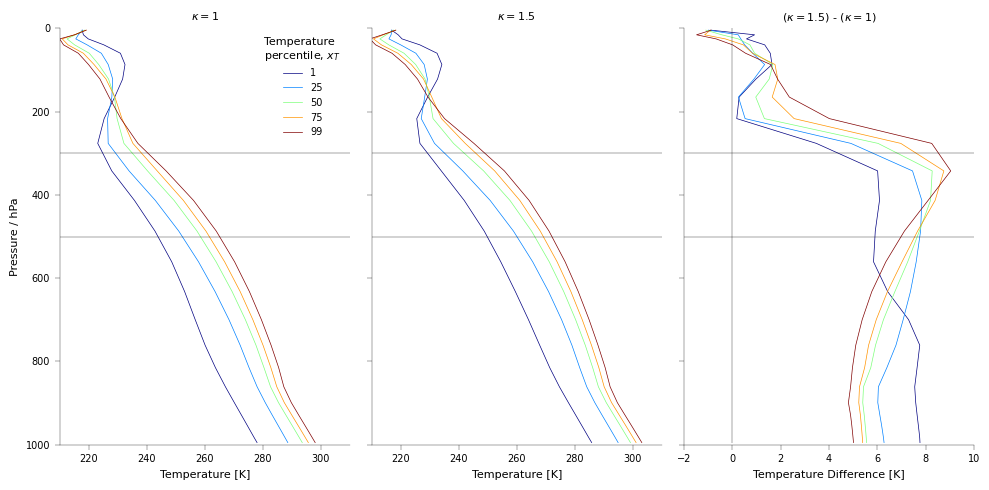

In [67]:
color_seq_exp = plt.cm.jet(np.linspace(0,1,len(quant_plot_temp_profile)))

fig, ax = plt.subplots(1,3, figsize=(10, 5), sharey=True)
for k, quant in enumerate(quant_plot_temp_profile):
    for i in range(n_exp):
        ax[i].set_title(f"$\kappa={tau_lw[i]}$")
        ax[i].plot(np.average(temp_profile_quant3[i, :, k], axis=0, weights=lat_weights_use), ds[0].pfull, color=color_seq_exp[k], label=quant)
    ax[2].plot(np.average(temp_profile_quant3[1, :, k]-temp_profile_quant3[0, :, k], axis=0, weights=lat_weights_use), 
            ds[0].pfull, color=color_seq_exp[k], label=quant)
ax[0].invert_yaxis()
ax[0].legend(title='Temperature\npercentile, $x_T$')
ax[0].set_ylim(1000, 0)
ax[0].set_xlim(210, 310)
ax[1].set_xlim(210, 310)
ax[0].hlines([300, 500], 210, 310, color='k', lw=ax_linewidth)
ax[1].hlines([300, 500], 210, 310, color='k', lw=ax_linewidth)
ax[2].set_xlim(-2, 10)
ax[2].vlines(0, p_surface/100, 0, color='k', lw=ax_linewidth)
ax[2].hlines([300, 500], -2, 10, color='k', lw=ax_linewidth)
ax[0].set_ylim(1000, 0)
ax[0].set_xlabel('Temperature [K]')
ax[1].set_xlabel('Temperature [K]')
ax[2].set_xlabel('Temperature Difference [K]')
ax[2].set_title(f"($\kappa={tau_lw[1]}$) - ($\kappa={tau_lw[0]}$)")
ax[0].set_ylabel('Pressure / hPa')
plt.tight_layout()